In [17]:
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np

## Load models

In [18]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('models/shape_predictor_5_face_landmarks.dat')

## Load Images

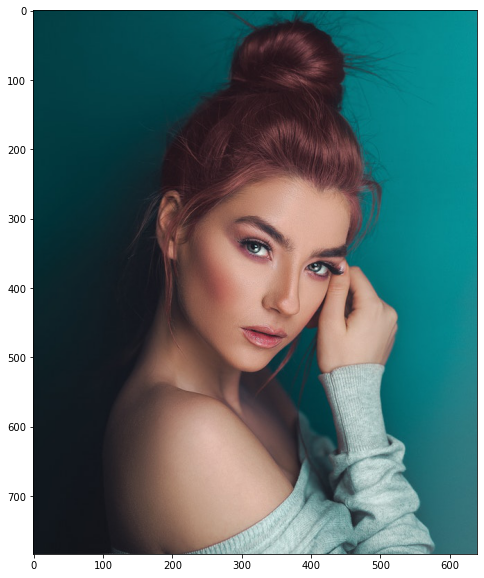

In [63]:
img = dlib.load_rgb_image('imgs/01.jpg') # 이미지를 rgb시스템으로 로드함

plt.figure(figsize=(16,10))
plt.imshow(img)

## Find Faces

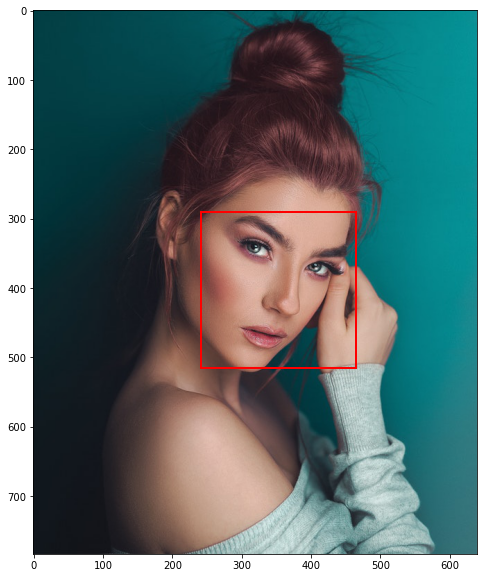

In [64]:
img_result = img.copy()

dets = detector(img,1)

if len(dets) == 0:
    print('cannot find faces!')
    
fig, ax = plt.subplots(1, figsize=(16,10))

for det in dets:
    x,y,w,h = det.left(),det.top(),det.width(),det.height()
    
    rect = patches.Rectangle((x,y),w,h, linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

ax.imshow(img_result)

## Find Landmarks 5points

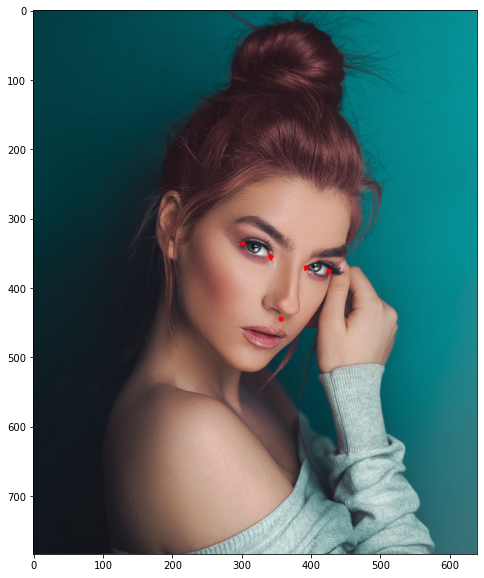

In [24]:
fig,ax = plt.subplots(1, figsize=(16,10))

objs = dlib.full_object_detections() # 얼굴을 수평으로 돌릴때 사용할 것

for detection in dets:
    s = sp(img,detection)
    objs.append(s) # shape를 넣어줌
    
    for point in s.parts(): # part는 5개임
        circle = patches.Circle((point.x,point.y), radius=3,edgecolor='r',facecolor='r')
        ax.add_patch(circle)
        
ax.imshow(img_result)

## Align Faces

In [25]:
# 얼굴 수평으로 맞추기

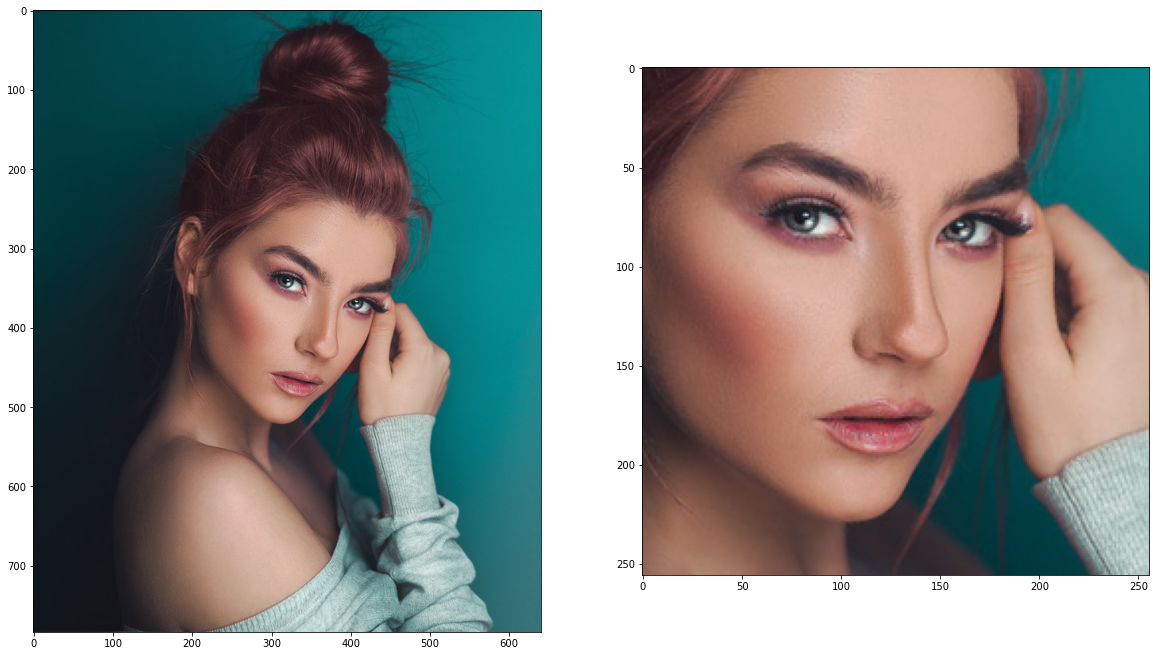

In [31]:
faces = dlib.get_face_chips(img, objs, size=256, padding=0.3)

fig, axes = plt.subplots(1, len(faces)+1, figsize=(20,16))

axes[0].imshow(img) #원본이미지

for i, face in enumerate(faces): # 얼굴들 찾아냄(여러개면 여러개)
    axes[i+1].imshow(face)

## Functionalize

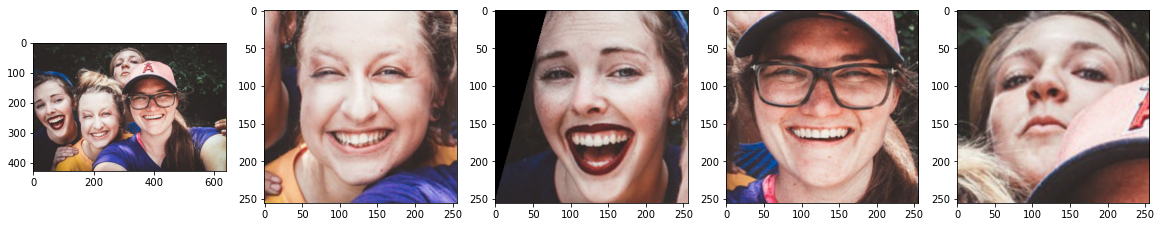

In [56]:
def align_faces(img):
    dets = detector(img,1)
    
    objs = dlib.full_object_detections()
    
    for detection in dets:
        s = sp(img, detection)
        objs.append(s)
        
    faces = dlib.get_face_chips(img,objs, size=256,padding=0.35)
    
    return faces

# test
test_img = dlib.load_rgb_image('imgs/02.jpg')

test_faces = align_faces(test_img)

fig,axes = plt.subplots(1, len(test_faces)+1, figsize=(20,16))
axes[0].imshow(test_img)

for i, face in enumerate(test_faces):
    axes[i+1].imshow(face)

## Load BeautyGAN Pretrained

In [93]:
tf.compat.v1.disable_eager_execution()
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

sess = tf.compat.v1.Session()
saver = tf.compat.v1.train.import_meta_graph('models/model.meta',clear_devices=False,import_scope=None)
saver.restore(sess, tf.train.latest_checkpoint('models'))
graph = tf.compat.v1.get_default_graph()

X = graph.get_tensor_by_name('X:0') # source 노메이크업
Y = graph.get_tensor_by_name('Y:0') # reference 따라할 메이크업 이미지
Xs = graph.get_tensor_by_name('generator/xs:0') # output

INFO:tensorflow:Restoring parameters from models\model


## Preprocess and Postprocess Functions

In [95]:
def preprocess(img):
    return img.astype(np.float32)/127.5 - 1. # 이미지 파일을 -1~1 사이의 실수타입으로 바꿈

def postprocess(img):
    return ((img + 1.)*127.5).astype(np.uint8) # 전처리의 반대

## Load Images

In [101]:
img1 = dlib.load_rgb_image('imgs/10.jpg') # 소스이미지
img1_faces = align_faces(img1)

img2 = dlib.load_rgb_image('imgs/makeup/XMY-014.png') # 메이크업한 이미지
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1,2,figsize=(16,10))
axes[0].imshow(img1_faces[0])
axes[1].imshow(img2_faces[0])

RuntimeError: Unable to open file: imgs/10.jpg

## Run

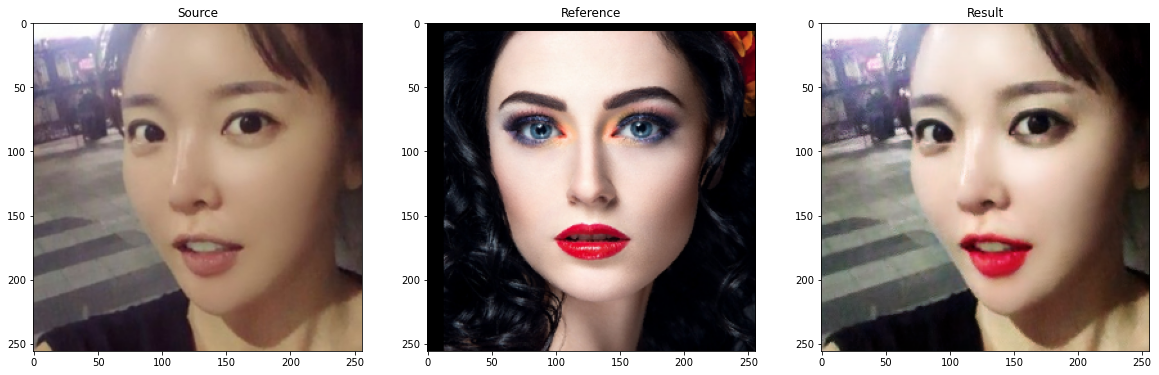

In [100]:

src_img = img1_faces[0]
ref_img = img2_faces[0]

X_img = preprocess(src_img)
X_img = np.expand_dims(X_img, axis=0) # 차원을 추가해야 cnn tensorflow에 돌릴수 있음 (1,256,256,3)

Y_img = preprocess(ref_img)
Y_img = np.expand_dims(Y_img, axis =0)


output = sess.run(Xs, feed_dict={
    X: X_img,
    Y: Y_img
})

output_img = postprocess(output[0])

fig, axes = plt.subplots(1,3,figsize=(20,10))
axes[0].set_title('Source')
axes[0].imshow(src_img)
axes[1].set_title('Reference')
axes[1].imshow(ref_img)
axes[2].set_title('Result')
axes[2].imshow(output_img)